In [1]:
# Install Required Libraries (Uncomment if not installed)
!pip install h2o scikit-learn pandas matplotlib imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=687e200cea5d67db6558d3d76e9269e1a4f02f3d3cfcef0595481e0947c5f68e
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o


In [6]:
# Import Necessary Libraries
import h2o
from h2o.automl import H2OAutoML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE


In [7]:
# Start H2O
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 min 20 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 19 days
H2O_cluster_name:,H2O_from_python_unknownUser_kmdu8s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [8]:
# Load Dataset
data = h2o.import_file("diabetes_prediction_dataset.csv")
data['diabetes'] = data['diabetes'].asfactor()  # Convert target to categorical

# Convert H2O Frame to Pandas for Preprocessing
df = data.as_data_frame()

# Identify Categorical Columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Encode Categorical Features using One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Split Features & Target
X = df_encoded.drop(columns=['diabetes'])
y = df['diabetes'].astype(int)  # Convert target to integer


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [9]:
# Handling Imbalanced Data with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert Back to Pandas DataFrame
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['diabetes'] = y_resampled

# Convert Pandas DataFrame to H2O Frame
data_balanced = h2o.H2OFrame(balanced_df)
data_balanced['diabetes'] = data_balanced['diabetes'].asfactor()  # Ensure target is categorical


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
# Split Data into Train & Test
train, test = data_balanced.split_frame(ratios=[0.8], seed=42)
test_original = h2o.assign(test, "test_original")  # Preserve original test set


In [11]:
# Configure AutoML
predictors = data_balanced.columns[:-1]  # Exclude target column
response = 'diabetes'

aml = H2OAutoML(
    max_models=20,
    seed=42,
    max_runtime_secs=300,
    include_algos=["GBM", "XGBoost", "GLM", "DRF"],
    balance_classes=True,
    stopping_metric="AUC",
    stopping_rounds=3,
    stopping_tolerance=0.001,
    nfolds=5
)

# Train AutoML Models
print("\nTraining AutoML models...\n")
aml.train(x=predictors, y=response, training_frame=train)



Training AutoML models...

AutoML progress: |
21:52:46.467: Stopping tolerance set by the user is < 70% of the recommended default of 0.0026130689162154157, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20250321_215246


Model Summary: 
    number_of_trees
--  -----------------
    38

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.013179268620141439
RMSE: 0.11480099572800508
LogLoss: 0.046257411679804926
Mean Per-Class Error: 0.01682524607762448
AUC: 0.998624602001429
AUCPR: 0.9987328116216926
Gini: 0.997249204002858

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46627807925487386
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      72486  626    0.0086   (626.0/73112.0)
1      1840   71501  0.0251   (1840.0/73341.0)
Total  74326  72127  0.0168   (2466.0/146453.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466278     0.983048  170
max f2                       0.263641     0.983662  239
max f0point5                 0.637816     0.99085   123
max accuracy                 0.472545     0.983162  168
max precision                0.999818     1         0
max recall                   0.00323065   1         390
max specificity              0.999818     1         0
max absolute_mcc             0.472545     0.966474  168
max min_per_class_accuracy   0.355409     0.981797  205
max mean_per_class_accuracy  0.472545     0.983176  168
max tns                      0.999818     73112     0
max fns                      0.999818     55275     0
max fps                      0.000172673  73112     399
max tps                      0.00323065   73341     390
max tnr                      0.999818     1         0
max fnr                      0.999818     0.753671  0
max fpr                      0.000172673  1         399
max tpr                      0.00323065   1         390

Gains/Lift Table: Avg response rate: 50.08 %, avg score: 50.08 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100032                   0.999902           1.99688     1.99688            1                0.999923     1                           0.999923            0.0199752       0.0199752                  99.6878   99.6878            0.0199752
2        0.0200132                   0.999879           1.99688     1.99688            1                0.999889     1                           0.999906            0.0199888       0.039964                   99.6878   99.6878            0.039964
3        0.0300369                   0.999861           1.99688     1.99688            1                0.99987      1                           0.999894            0.0200161       0.0599801                  99.6878   99.6878            0.0599801
4        0.040047                    0.999848           1.99688     1.99688            1                0.999854     1                           0.999884            0.0199888       0.0799689                  99.6878   99.6878            0.0799689
5        0.0500707                   0.999835           1.99688     1.99688            1                0.999841     1                           0.999875            0.0200161       0.099985                   99.6878   99.6878            0.099985
6        0.100012                    0.999777           1.99688     1.99688            1                0.999805     1                           0.99984             0.0997259       0.199711                   99.6878   99.6878            0.199711
7        0.150028                    0


Best Model Selected:
 Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20250321_215246


Model Summary: 
    number_of_trees
--  -----------------
    38

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.013179268620141439
RMSE: 0.11480099572800508
LogLoss: 0.046257411679804926
Mean Per-Class Error: 0.01682524607762448
AUC: 0.998624602001429
AUCPR: 0.9987328116216926
Gini: 0.997249204002858

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46627807925487386
       0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      72486  626    0.0086   (626.0/73112.0)
1      1840   71501  0.0251   (1840.0/73341.0)
Total  74326  72127  0.0168   (2466.0/146453.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466278     0.983048  170
max f2                      

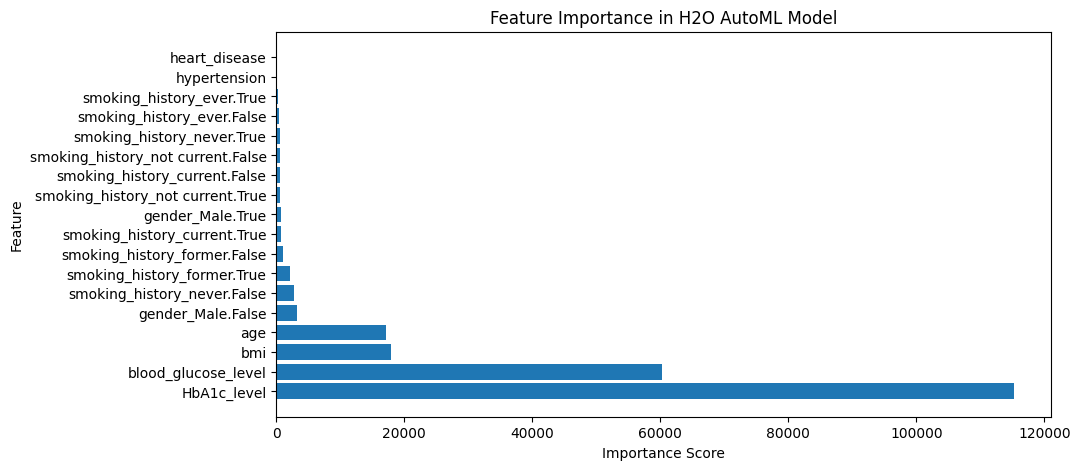

In [12]:
# Get Best Model
leader = aml.leader
print("\nBest Model Selected:\n", leader)

# Feature Importance
print("\nExtracting Feature Importance...\n")
feature_importance = leader.varimp(use_pandas=True)
print(feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance["variable"], feature_importance["relative_importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance in H2O AutoML Model")
plt.show()


In [13]:
# Generate Predictions
print("\nGenerating Predictions...\n")
preds = leader.predict(test_original)
test_with_preds = test_original.cbind(preds[['p1']])



Generating Predictions...

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


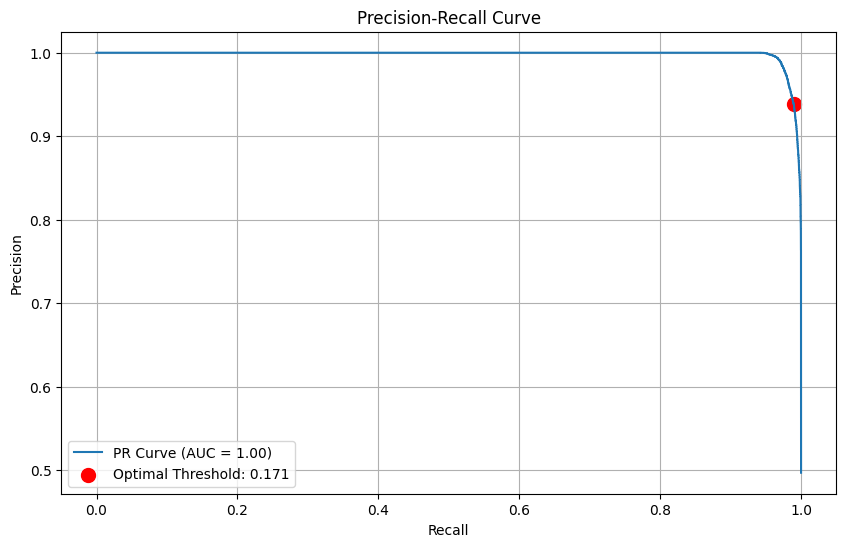

In [14]:
# Convert to Pandas
test_df = test_with_preds.as_data_frame()
y_true = test_df[response].astype(int).values  # Convert to int
y_scores = test_df['p1'].values

# Compute Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Find Optimal Threshold (Maximizing F2-Score)
f2_scores = (5 * precision * recall) / (4 * precision + recall + 1e-9)
optimal_idx = np.argmax(f2_scores)
optimal_threshold = float(thresholds[optimal_idx])

# Visualize Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.scatter(recall[optimal_idx], precision[optimal_idx],
            c='red', s=100, label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Apply Optimal Threshold
print("\nApplying Optimal Threshold & Evaluating...\n")
final_preds = leader.predict(test_original)
test_final = test_original.cbind(final_preds)
test_final['predicted_class'] = (test_final['p1'] > optimal_threshold).ifelse(1, 0)



Applying Optimal Threshold & Evaluating...

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


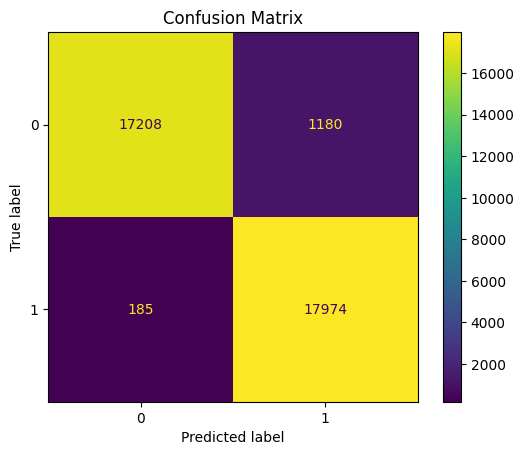

In [16]:
# Convert to Pandas for Confusion Matrix
test_final_df = test_final.as_data_frame()
y_pred_optimal = test_final_df['predicted_class'].values

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [17]:
# Print Model Performance
performance = leader.model_performance(test_final)
print("\nFinal Performance Metrics:\n", performance)



Final Performance Metrics:
 ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.015315988783983436
RMSE: 0.12375778272085937
LogLoss: 0.0525645693898982
Mean Per-Class Error: 0.019548023769395524
AUC: 0.9979388045963314
AUCPR: 0.9981025988937353
Gini: 0.9958776091926629

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5140950296606336
       0      1      Error    Rate
-----  -----  -----  -------  ---------------
0      18223  165    0.009    (165.0/18388.0)
1      547    17612  0.0301   (547.0/18159.0)
Total  18770  17777  0.0195   (712.0/36547.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.514095     0.980187  150
max f2                       0.172078     0.978997  273
max f0point5                 0.768531     0.989385  83
max accuracy                 0.514095     0.980518  150
max precision      

In [18]:
# Cleanup
h2o.shutdown()


H2O session _sid_9ee8 closed.


<ipython-input-18-9d706e9931df>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
